In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls

#import warnings
#warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [335]:
train.shape

(1460, 81)

In [336]:
test.shape

(1459, 80)

In [1018]:
train.SalePrice.head(5)

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [3]:
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
182,183,20,RL,60.0,9060,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,120000
458,459,70,RM,NaN,5100,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2008,WD,Normal,161000
377,378,60,FV,102.0,11143,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,WD,Normal,340000
155,156,50,RL,60.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Normal,79000
478,479,20,RL,79.0,10637,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,297000


In [4]:
train.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [3]:
dic2=train.BldgType.value_counts().to_dict()

In [3]:
dic2={'1Fam': 1, '2fmCon': 2, 'Duplex': 3, 'Twnhs': 4, 'TwnhsE': 5}

In [4]:
train["BldgType"]=train["BldgType"].map(dic2)
test["BldgType"]=test["BldgType"].map(dic2)

In [10]:
train.LotShape.value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

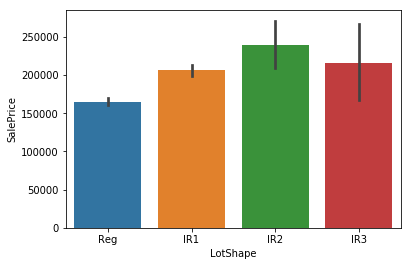

In [100]:
sns.barplot(x="LotShape", y="SalePrice", data=train);

In [5]:
train.LotShape = train.LotShape.map({"Reg":0, "IR1":1, "IR2":2, "IR3":3})
test.LotShape = test.LotShape.map({"Reg":0, "IR1":1, "IR2":2, "IR3":3})

In [12]:
train.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [6]:
train.SaleCondition = train.SaleCondition.map({"Normal":0, "Partial":1, "Abnotml":2, "Family":3, "Alloca":4, "AdjLand":5})
test.SaleCondition = test.SaleCondition.map({"Normal":0, "Partial":1, "Abnotml":2, "Family":3, "Alloca":4, "AdjLand":5})

In [7]:
train['SaleCondition']=train['SaleCondition'].fillna(6);
test['SaleCondition']=test['SaleCondition'].fillna(6);

In [204]:
train.SaleCondition.value_counts().sum()

1460

In [13]:
train.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

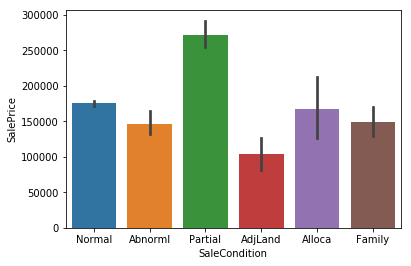

In [14]:
sns.barplot(x="SaleCondition", y="SalePrice", data=train);

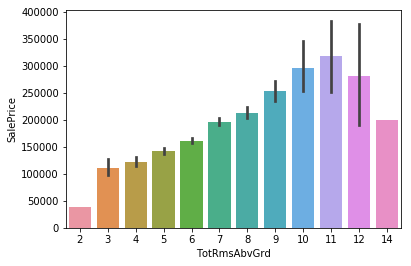

In [15]:
sns.barplot(x="TotRmsAbvGrd", y="SalePrice", data=train);

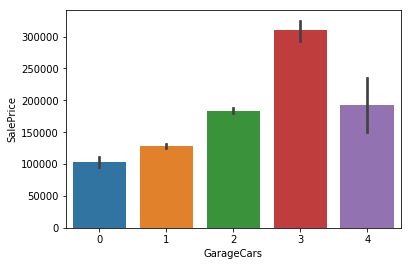

In [218]:
sns.barplot(x="GarageCars", y="SalePrice", data=train);

In [220]:
train.GarageCars.value_counts().sum()

1460

In [202]:
train.GrLivArea.value_counts().sum()

1460

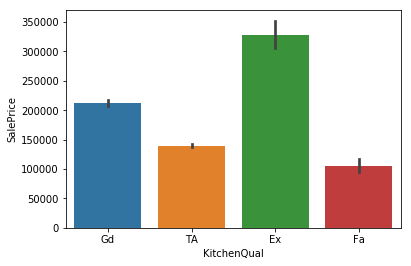

In [193]:
sns.barplot(x="KitchenQual", y="SalePrice", data=train);

In [8]:
train["KitchenQual"]=train["KitchenQual"].map({'Gd':0,'TA':1,'Ex':2,'Fa':3})
test["KitchenQual"]=test["KitchenQual"].map({'Gd':0,'TA':1,'Ex':2,'Fa':3})

In [181]:
train.YearRemodAdd.value_counts().sum()

1460

In [154]:
train.YearBuilt.value_counts().sum()

1460

In [210]:
train.KitchenAbvGr.value_counts().sum()

1460

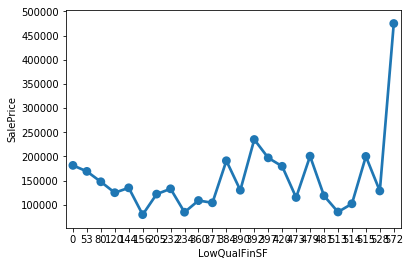

In [17]:
sns.pointplot(x="LowQualFinSF", y="SalePrice", data=train);

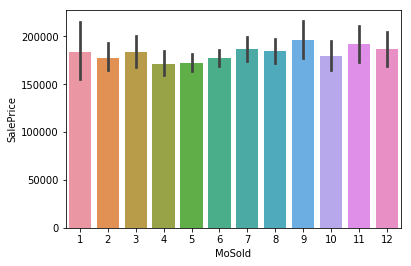

In [81]:
sns.barplot(x="MoSold", y="SalePrice", data=train);

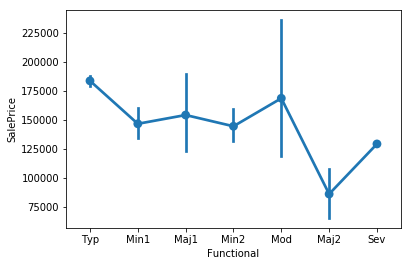

In [1101]:
sns.pointplot(x="Functional", y="SalePrice", data=train);

In [9]:
test['Functional'] = test['Functional'].fillna(0)

In [10]:
train['Functional']=train['Functional'].map({'Maj1': 4, 'Maj2': 5, 'Min1': 2, 'Min2': 3, 'Mod': 1, 'Sev': 6, 'Typ': 0})
test['Functional']=test['Functional'].map({'Maj1': 4, 'Maj2': 5, 'Min1': 2, 'Min2': 3, 'Mod': 1, 'Sev': 6, 'Typ': 0, 0:0})

In [1109]:
test.Functional.value_counts().sum()

1459

In [122]:
train.Neighborhood.value_counts().sum()

1460

In [11]:
dic ={'Blmngtn': 1,
 'Blueste': 2,
 'BrDale': 3,
 'BrkSide': 4,
 'ClearCr': 5,
 'CollgCr': 6,
 'Crawfor': 7,
 'Edwards': 8,
 'Gilbert': 9,
 'IDOTRR': 10,
 'MeadowV': 11,
 'Mitchel': 12,
 'NAmes': 13,
 'NPkVill': 14,
 'NWAmes': 15,
 'NoRidge': 16,
 'NridgHt': 17,
 'OldTown': 18,
 'SWISU': 19,
 'Sawyer': 20,
 'SawyerW': 21,
 'Somerst': 22,
 'StoneBr': 23,
 'Timber': 24,
 'Veenker': 25}

In [12]:
train["Neighborhood"]=train["Neighborhood"].map(dic)
test["Neighborhood"]=test["Neighborhood"].map(dic)

In [825]:
train.PoolArea.value_counts().sort_values()

738       1
648       1
576       1
555       1
519       1
512       1
480       1
0      1453
Name: PoolArea, dtype: int64

In [13]:
train['PoolArea']=pd.cut(train['PoolArea'], [-.1,1,1000], labels=False)

In [14]:
test['PoolArea']=pd.cut(test['PoolArea'], [-.1,1,1000], labels=False)

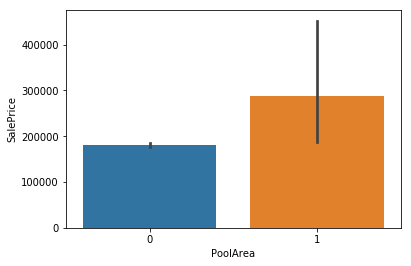

In [104]:
sns.barplot(x="PoolArea", y="SalePrice", data=train);

In [831]:
train.MasVnrArea.value_counts().sort_index()

0.0       861
1.0         2
11.0        1
14.0        1
16.0        7
18.0        2
22.0        1
24.0        1
27.0        1
28.0        1
30.0        2
31.0        1
32.0        1
34.0        1
36.0        1
38.0        1
40.0        4
41.0        1
42.0        3
44.0        3
45.0        2
46.0        1
48.0        1
50.0        3
51.0        1
53.0        1
54.0        2
56.0        1
57.0        1
60.0        2
         ... 
650.0       2
651.0       1
653.0       1
660.0       2
664.0       1
673.0       1
705.0       1
731.0       1
748.0       1
760.0       1
762.0       1
766.0       1
768.0       1
772.0       1
788.0       1
796.0       1
816.0       1
860.0       1
870.0       1
894.0       1
921.0       1
922.0       1
975.0       1
1031.0      1
1047.0      1
1115.0      1
1129.0      1
1170.0      1
1378.0      1
1600.0      1
Name: MasVnrArea, Length: 327, dtype: int64

In [15]:
train['MasVnrArea']=train['MasVnrArea'].fillna(0)
test['MasVnrArea']=test['MasVnrArea'].fillna(0)

In [16]:
train['MasVnrArea2'], masbins = pd.qcut(train['MasVnrArea'], 10, duplicates='drop', retbins=True, labels=False)

In [834]:
masbins

array([    0. ,    16. ,   116. ,   205.2,   335. ,  1600. ])

In [17]:
test['MasVnrArea2'] = pd.cut(test['MasVnrArea'], masbins, include_lowest=True, labels=False)

In [351]:
#train['MasVnrArea']= train['MasVnrArea'].map({0:0,1:1, 'nan':0})

In [193]:
#np.unique(train['MasVnrArea'])

array([  0.,   1.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [190]:
train['MasVnrArea'].value_counts().sum()

1452

In [93]:
train['ExterQual'].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [18]:
train['ExterQual']=train['ExterQual'].map({"TA":0, "Gd":1, "Ex":2, "Fa":3})
test['ExterQual']=test['ExterQual'].map({"TA":0, "Gd":1, "Ex":2, "Fa":3})

In [118]:
train['ExterQual'].value_counts()

Series([], Name: ExterQual, dtype: int64)

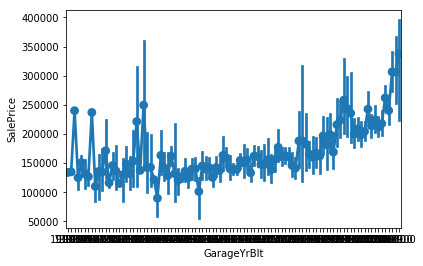

In [1098]:
sns.pointplot(x="GarageYrBlt", y="SalePrice", data=train);

In [1099]:
train.GarageYrBlt.describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [73]:
test['GarageArea2'] = test.GarageArea2.fillna(0)

In [78]:
test.GarageArea.describe()

count    1459.000000
mean      472.444825
std       217.326902
min         0.000000
25%       317.500000
50%       480.000000
75%       576.000000
max      1488.000000
Name: GarageArea, dtype: float64

In [19]:
test['GarageArea2'], garagebins= pd.qcut(test['GarageArea'], 10,duplicates='drop', retbins=True, labels=False)
train['GarageArea2'] = pd.cut(train['GarageArea'], garagebins, include_lowest=True, labels=False)
test['GarageArea2'] = test.GarageArea2.fillna(0)

In [20]:
train['Sf'] = train['1stFlrSF']+train['2ndFlrSF']+train['TotalBsmtSF']
test['Sf'] = test['1stFlrSF']+test['2ndFlrSF']+test['TotalBsmtSF']

In [21]:
train['Sf2'], sfbins= pd.qcut(train['Sf'], 10,duplicates='drop', retbins=True, labels=False)
test['Sf2'] = pd.cut(test['Sf'], sfbins, include_lowest=True, labels=False)
test['Sf2']=test['Sf2'].fillna(0)

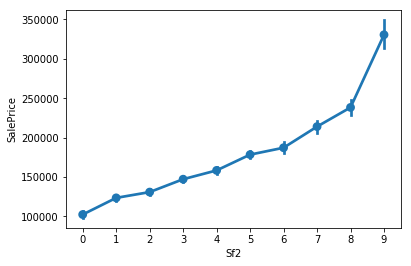

In [1292]:
sns.pointplot(x="Sf2", y="SalePrice", data=train);

In [23]:
test['Sf2']=test['Sf2'].fillna(0)

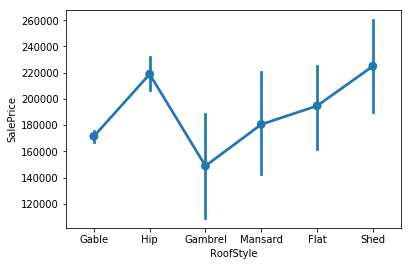

In [612]:
sns.pointplot(x="RoofStyle", y="SalePrice", data=train);

In [617]:
train.RoofStyle.value_counts().to_dict()

{'Flat': 13, 'Gable': 1141, 'Gambrel': 11, 'Hip': 286, 'Mansard': 7, 'Shed': 2}

In [22]:
train.RoofStyle=train.RoofStyle.map({'Flat': 0, 'Gable': 1, 'Gambrel': 2, 'Hip': 3, 'Mansard': 4, 'Shed': 5})
test.RoofStyle=test.RoofStyle.map({'Flat': 0, 'Gable': 1, 'Gambrel': 2, 'Hip': 3, 'Mansard': 4, 'Shed': 5})

In [600]:
train.HouseStyle.value_counts().to_dict()

{'1.5Fin': 154,
 '1.5Unf': 14,
 '1Story': 726,
 '2.5Fin': 8,
 '2.5Unf': 11,
 '2Story': 445,
 'SFoyer': 37,
 'SLvl': 65}

In [23]:
train.HouseStyle=train.HouseStyle.map({'1.5Fin': 0, '1.5Unf': 1, '1Story': 2, '2.5Fin': 3, '2.5Unf': 4, '2Story': 5, 'SFoyer': 6, 'SLvl': 7})
test.HouseStyle=test.HouseStyle.map({'1.5Fin': 0, '1.5Unf': 1, '1Story': 2, '2.5Fin': 3, '2.5Unf': 4, '2Story': 5, 'SFoyer': 6, 'SLvl': 7})

In [578]:
test.MSSubClass.value_counts().to_dict()

{20: 543,
 30: 70,
 40: 2,
 45: 6,
 50: 143,
 60: 276,
 70: 68,
 75: 7,
 80: 60,
 85: 28,
 90: 57,
 120: 95,
 150: 1,
 160: 65,
 180: 7,
 190: 31}

In [24]:
train.MSSubClass=train.MSSubClass.map({20: 0, 30: 1, 40: 2, 45: 3, 50: 4, 60: 5, 70: 6, 75: 7, 80: 8, 85: 9, 90: 10, 120: 11, 160: 12, 180: 13, 190: 14, 150:15})
test.MSSubClass=test.MSSubClass.map({20: 0, 30: 1, 40: 2, 45: 3, 50: 4, 60: 5, 70: 6, 75: 7, 80: 8, 85: 9, 90: 10, 120: 11, 160: 12, 180: 13, 190: 14, 150:15})

In [25]:
train.Condition1 = train.Condition1.map({'Artery': 0, 'Feedr': 1, 'Norm': 2, 'PosA': 3, 'PosN': 4, 'RRAe': 5, 'RRAn': 6,
 'RRNe': 7,  'RRNn': 8})
test.Condition1 = test.Condition1.map({'Artery': 0, 'Feedr': 1, 'Norm': 2, 'PosA': 3, 'PosN': 4, 'RRAe': 5, 'RRAn': 6,
 'RRNe': 7,  'RRNn': 8})

In [26]:
train['Bath']=(1/2)* train.HalfBath + train.FullBath
test['Bath']=(1/2)* test.HalfBath + test.FullBath

In [402]:
train.Bath.value_counts()

1.0    469
2.0    433
2.5    334
1.5    180
3.0     20
3.5     18
0.0      3
0.5      3
Name: Bath, dtype: int64

In [842]:
train.WoodDeckSF.value_counts().sort_index()

0      761
12       2
24       2
26       2
28       2
30       1
32       1
33       1
35       1
36       4
38       2
40       3
42       1
44       1
45       1
48       5
49       2
52       1
53       1
55       2
56       1
57       1
58       2
60       2
63       1
64       4
66       1
68       2
70       1
72       3
      ... 
421      1
426      1
431      2
436      1
439      1
441      1
448      1
466      1
468      1
474      1
476      1
486      2
495      1
500      1
503      1
509      1
511      1
517      1
519      1
536      1
550      1
574      1
576      1
586      1
635      1
668      1
670      1
728      1
736      1
857      1
Name: WoodDeckSF, Length: 274, dtype: int64

In [27]:
train.WoodDeckSF = train.WoodDeckSF.fillna(0)
test.WoodDeckSF = test.WoodDeckSF.fillna(0)

In [28]:
train['WoodDeckSF'], woodbins = pd.qcut(train['WoodDeckSF'], 10, duplicates='drop', retbins=True, labels=False)
test['WoodDeckSF'] = pd.cut(test['WoodDeckSF'], woodbins, include_lowest=True, labels=False)

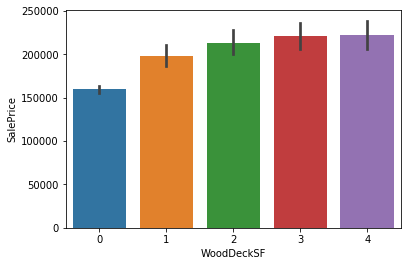

In [845]:
sns.barplot(x="WoodDeckSF", y="SalePrice", data=train);

In [29]:
train["Porch"] = train["OpenPorchSF"]+train["EnclosedPorch"]+train["3SsnPorch"]
test["Porch"] = test["OpenPorchSF"]+test["EnclosedPorch"]+test["3SsnPorch"]

In [1024]:
test.Porch.describe()

count    1459.000000
mean       74.351611
std        96.295266
min         0.000000
25%         0.000000
50%        46.000000
75%       104.000000
max      1207.000000
Name: Porch, dtype: float64

In [30]:
test['Porch2'], porchbins = pd.qcut(test['Porch'], 10, duplicates='drop', retbins=True, labels=False)
train['Porch2'] = pd.cut(train['Porch'], porchbins, include_lowest=True, labels=False)

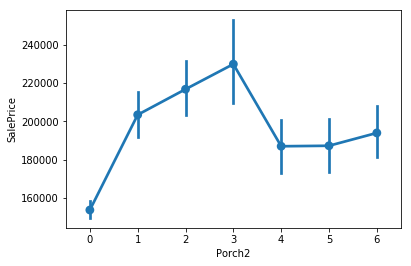

In [1026]:
sns.pointplot(x='Porch2', y='SalePrice',data=train)

In [31]:
train['LotArea'], lotbins = pd.qcut(train['LotArea'], 10, duplicates='drop', retbins=True, labels=False)
test['LotArea'] = pd.cut(test['LotArea'], lotbins, include_lowest=True, labels=False)

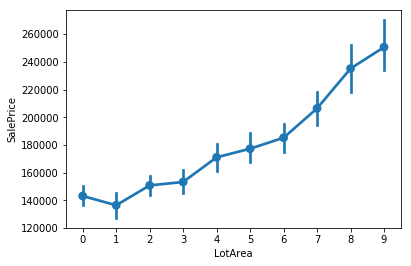

In [868]:
sns.pointplot(x='LotArea', y='SalePrice',data=train)

In [32]:
train.LotFrontage = train.LotFrontage.fillna(0)
test.LotFrontage = test.LotFrontage.fillna(0)
train['LotFrontage2'], lotfrontbins = pd.qcut(train['LotFrontage'], 10, duplicates='drop', retbins=True, labels=False)
test['LotFrontage2'] = pd.cut(test['LotFrontage'], lotfrontbins, include_lowest=True, labels=False)

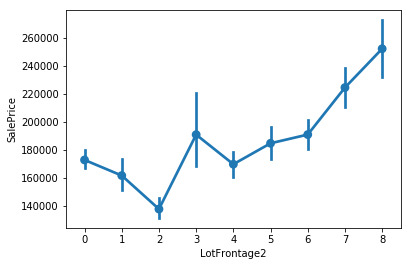

In [1347]:
sns.pointplot(x='LotFrontage2', y='SalePrice',data=train)

In [33]:
train.Fence = train.Fence.map({'MnPrv': 1,'GdPrv': 2,'GdWo': 3,'MnWw': 4})
test.Fence = test.Fence.map({'MnPrv': 1,'GdPrv': 2,'GdWo': 3,'MnWw': 4})
train.Fence = train.Fence.fillna(0)
test.Fence = test.Fence.fillna(0)

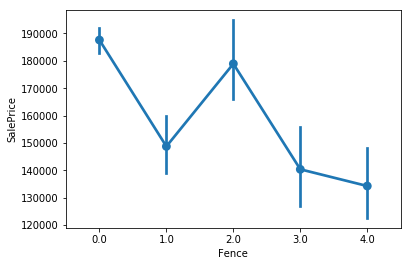

In [1362]:
sns.pointplot(x='Fence', y='SalePrice',data=train)

In [34]:
train.GarageCars=train.GarageCars.fillna(0)
test.GarageCars=test.GarageCars.fillna(0)
train.Porch=train.Porch.fillna(0)
test.Porch=test.Porch.fillna(0)
train.WoodDeckSF = train.WoodDeckSF.fillna(0)
test.WoodDeckSF = test.WoodDeckSF.fillna(0)
train.KitchenQual = train.KitchenQual.fillna(0)
test.KitchenQual = test.KitchenQual.fillna(0)
test.TotalBsmtSF =test.TotalBsmtSF.fillna(0)

In [306]:
train.CentralAir.value_counts().sum()

1460

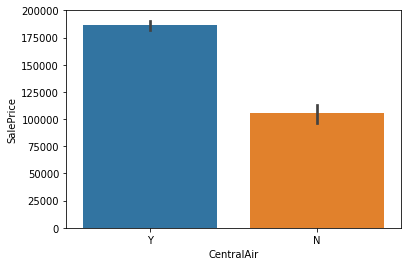

In [307]:
sns.barplot(x="CentralAir", y="SalePrice", data=train);

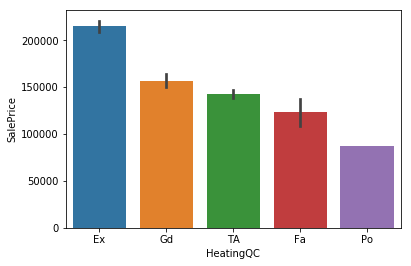

In [379]:
sns.barplot(x="HeatingQC", y="SalePrice", data=train);

In [384]:
train.HeatingQC.value_counts().to_dict()

{'Ex': 741, 'Fa': 49, 'Gd': 241, 'Po': 1, 'TA': 428}

In [35]:
train['HeatingQC']=train['HeatingQC'].map({'Ex': 0, 'Fa': 1, 'Gd': 2, 'Po': 3, 'TA': 4})
test['HeatingQC']=test['HeatingQC'].map({'Ex': 0, 'Fa': 1, 'Gd': 2, 'Po': 3, 'TA': 4})

In [36]:
train['Heating']=train['Heating'].map({'GasA': 0, 'GasW': 1, 'Grav': 2, 'Wall': 3, 'OthW':4, 'Floor':5})
test['Heating']=test['Heating'].map({'GasA': 0, 'GasW': 1, 'Grav': 2, 'Wall': 3, 'OthW':4, 'Floor':5})

In [37]:
train['CentralAir']=train['CentralAir'].map({"Y":0, "N":1})
test['CentralAir']=test['CentralAir'].map({"Y":0, "N":1})

In [38]:
train['2ndFlr'], SecSfbins = pd.qcut(train['2ndFlrSF'], 10, duplicates='drop', retbins=True, labels=False)
test['2ndFlr'] = pd.cut(test['2ndFlrSF'], SecSfbins, include_lowest=True, labels=False)

In [878]:
SecSfbins

array([    0. ,   455.4,   672. ,   796.2,   954.2,  2065. ])

In [895]:
train['2ndFlrSF'].describe()

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

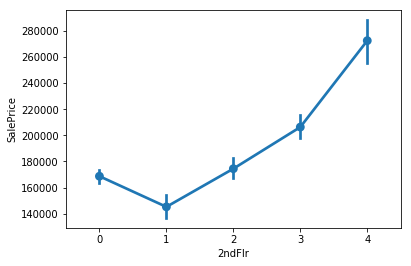

In [877]:
sns.pointplot(x="2ndFlr", y="SalePrice", data=train);

In [851]:
train.LowQualFinSF.value_counts()

0      1434
80        3
360       2
528       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
371       1
572       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
513       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64

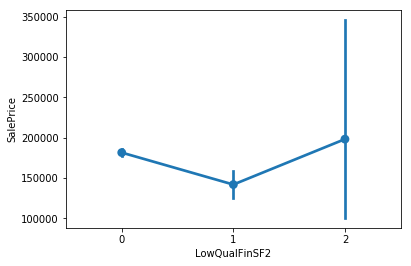

In [943]:
sns.pointplot(x="LowQualFinSF2", y="SalePrice", data=train);

In [39]:
#This turns out to be a bad idea
train['LowQualFinSF2']=pd.cut(train['LowQualFinSF'], [-.1,1,500,1000], include_lowest=True, labels=False)
test['LowQualFinSF2'] = pd.cut(test['LowQualFinSF'], [-.1,1,500,1000], include_lowest=True, labels=False)

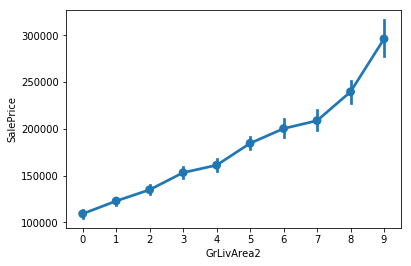

In [954]:
sns.pointplot(x="GrLivArea2", y='SalePrice', data=train)

In [40]:
#This turns out to be a bad idea
train['GrLivArea2'], grlivbins = pd.qcut(train['GrLivArea'], 10, duplicates='drop', retbins=True, labels=False)
test['GrLivArea2'] = pd.cut(test['GrLivArea'], grlivbins, include_lowest=True, labels=False)

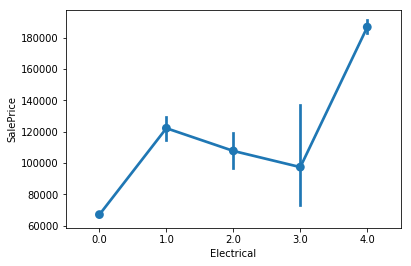

In [984]:
sns.pointplot(x="Electrical", y='SalePrice', data=train)

In [978]:
train.Electrical.value_counts().to_dict()

{'FuseA': 94, 'FuseF': 27, 'FuseP': 3, 'Mix': 1, 'SBrkr': 1334}

In [41]:
train['Electrical']= train.Electrical.fillna(0)
test['Electrical']=test.Electrical.fillna(0)

In [989]:
train.Electrical.value_counts().sum()

1460

In [42]:
train.Electrical=train.Electrical.map({'FuseA': 1, 'FuseF': 2, 'FuseP': 3, 'Mix': 0, 'SBrkr': 4, 0:0})
test.Electrical=test.Electrical.map({'FuseA': 1, 'FuseF': 2, 'FuseP': 3, 'Mix': 0, 'SBrkr': 4, 0:0})

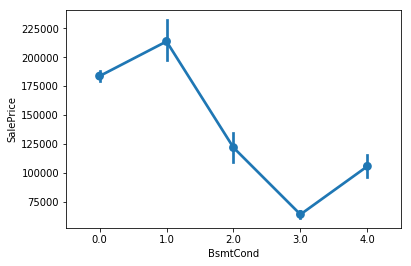

In [792]:
sns.pointplot(x="BsmtCond", y='SalePrice', data=train)

In [43]:
train.BsmtCond = train.BsmtCond.map({'TA':0,'Gd':1,'Fa':2,'Po':3})
test.BsmtCond = test.BsmtCond.map({'TA':0,'Gd':1,'Fa':2,'Po':3})

In [44]:
train.BsmtCond = train.BsmtCond.fillna(4)
test.BsmtCond = test.BsmtCond.fillna(4)

In [453]:
train['OverallQual'].value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [45]:
test.TotalBsmtSF =test.TotalBsmtSF.fillna(0)

In [753]:
train.TotalBsmtSF.describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [45]:
#This turns out to be a bad idea
train['TotalBsmtSF2'], Bsmtbins = pd.qcut(train['TotalBsmtSF'], 10, duplicates='drop', retbins=True, labels=False)
test['TotalBsmtSF2'] = pd.cut(test['TotalBsmtSF'], Bsmtbins, include_lowest=True, labels=False)

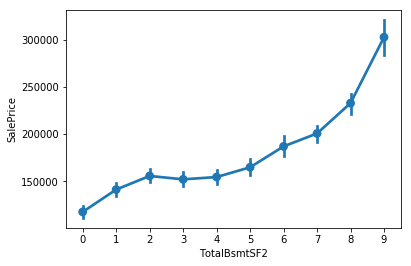

In [910]:
sns.pointplot(x='TotalBsmtSF2',y='SalePrice',data=train)

In [854]:
train.MiscVal.value_counts()

0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64

In [46]:
train['MiscVal2'] = pd.cut(train['MiscVal'], [0,2,5000, 10000, 15000, 20000], include_lowest=True, labels=False)
test['MiscVal2'] = pd.cut(test['MiscVal'], [0,2,5000, 10000, 15000, 20000], include_lowest=True, labels=False)

In [47]:
train.MiscVal =train.MiscVal.fillna(0)
test.MiscVal =test.MiscVal.fillna(0)

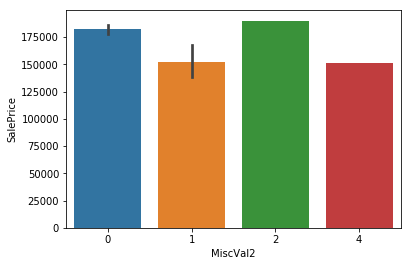

In [904]:
sns.barplot(x="MiscVal2", y="SalePrice", data=train)

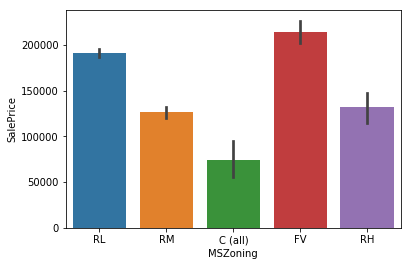

In [488]:
sns.barplot(x="MSZoning", y="SalePrice", data=train)

In [490]:
test.MSZoning.value_counts().to_dict()

{'C (all)': 15, 'FV': 74, 'RH': 10, 'RL': 1114, 'RM': 242}

In [48]:
train['MSZoning'] = train['MSZoning'].map({'C (all)': 1, 'FV': 2, 'RH': 3, 'RL': 4, 'RM': 5})
test['MSZoning'] = test['MSZoning'].map({'C (all)': 1, 'FV': 2, 'RH': 3, 'RL': 4, 'RM': 5})
test['MSZoning'] = test['MSZoning'].fillna(6)

In [49]:
train['Year'] = 2010-train.YearBuilt
test['Year'] = 2010-test.YearBuilt

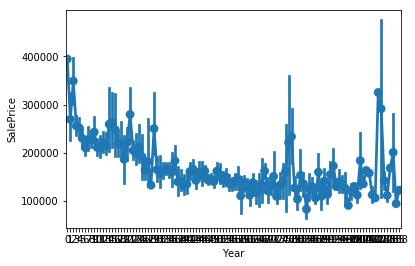

In [204]:
sns.pointplot(x='Year', y='SalePrice', data=train)

In [807]:
train['Year'].describe()

count    1460.000000
mean       99.267808
std        30.202904
min         0.000000
25%        82.000000
50%       101.000000
75%       128.000000
max       138.000000
Name: Year, dtype: float64

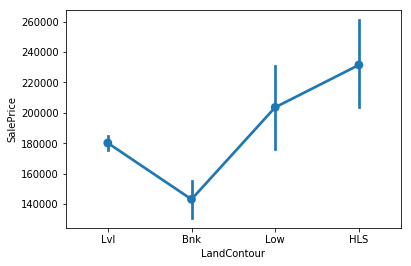

In [154]:
sns.pointplot(x='LandContour', y='SalePrice', data=train)

In [50]:
train.LandContour = train.LandContour.map({'Bnk': 0, 'HLS': 3, 'Low': 2, 'Lvl': 1})
test.LandContour = test.LandContour.map({'Bnk': 0, 'HLS': 3, 'Low': 2, 'Lvl': 1})

In [51]:
test.Exterior1st=test.Exterior1st.fillna(0)#.value_counts().to_dict()

In [52]:
train.Exterior1st=train.Exterior1st.map({'AsbShng': 1, 'AsphShn': 2, 'BrkComm': 3, 'BrkFace': 4, 'CBlock': 5, 'CemntBd': 6, 'HdBoard': 7, 'ImStucc': 8, 'MetalSd': 9, 'Plywood': 10, 'Stone': 11, 'Stucco': 12, 'VinylSd': 13, 'Wd Sdng': 14, 'WdShing': 15})
test.Exterior1st=test.Exterior1st.map({'AsbShng': 1, 'AsphShn': 2, 'BrkComm': 3, 'BrkFace': 4, 'CBlock': 5, 'CemntBd': 6, 'HdBoard': 7, 'ImStucc': 8, 'MetalSd': 9, 'Plywood': 10, 'Stone': 11, 'Stucco': 12, 'VinylSd': 13, 'Wd Sdng': 14, 'WdShing': 15})
test.Exterior1st=test.Exterior1st.fillna(0)

In [1153]:
train.Foundation.value_counts().to_dict()

{'BrkTil': 146, 'CBlock': 634, 'PConc': 647, 'Slab': 24, 'Stone': 6, 'Wood': 3}

In [53]:
train.Foundation=train.Foundation.map({'BrkTil': 0, 'CBlock': 1, 'PConc': 2, 'Slab': 3, 'Stone': 4, 'Wood': 5})
test.Foundation=test.Foundation.map({'BrkTil': 0, 'CBlock': 1, 'PConc': 2, 'Slab': 3, 'Stone': 4, 'Wood': 5})

In [1092]:
train['MasVnrType2'] = train.MasVnrType.map({'BrkCmn': 1, 'BrkFace': 2, 'None': 3, 'Stone': 4})
test['MasVnrType2'] = test.MasVnrType.map({'BrkCmn': 1, 'BrkFace': 2, 'None': 3, 'Stone': 4})
train['MasVnrType2'] = train['MasVnrType2'].fillna(0)
test['MasVnrType2'] = test['MasVnrType2'].fillna(0)

In [1146]:
train['SaleType2'] =train.SaleType.map({'COD': 0, 'CWD': 1, 'Con': 2, 'ConLD': 3, 'ConLI': 4, 'ConLw': 5, 'New': 6, 'Oth': 7, 'WD': 8})
test['SaleType2'] =test.SaleType.map({'COD': 0, 'CWD': 1, 'Con': 2, 'ConLD': 3, 'ConLI': 4, 'ConLw': 5, 'New': 6, 'Oth': 7, 'WD': 8})
test['SaleType2'] = test['SaleType2'].fillna(7)

In [1191]:
train['LandSlope2'] = train.LandSlope.map({'Gtl': 0, 'Mod': 1, 'Sev': 2})
test['LandSlope2'] = test.LandSlope.map({'Gtl': 0, 'Mod': 1, 'Sev': 2})

In [1137]:
test.PavedDrive.value_counts()

Y    1301
N     126
P      32
Name: PavedDrive, dtype: int64

In [54]:
train.PavedDrive = train.PavedDrive.map({'N':0, 'P':1, 'Y':2})
test.PavedDrive = test.PavedDrive.map({'N':0, 'P':1, 'Y':2})

In [368]:
test.KitchenQual.value_counts().sum()

1458

In [1143]:
for feature in Features:
    print(feature, test[feature].value_counts().sum())

MasVnrType2 1459
MiscVal2 1459
2ndFlr 1459
OverallQual 1459
LotArea 1459
LotShape 1459
YrSold 1459
ExterQual 1459
LowQualFinSF 1459
MasVnrArea 1459
BsmtCond 1459
PoolArea 1459
GrLivArea2 1459
MoSold 1459
TotRmsAbvGrd 1459
SaleCondition 1459
Neighborhood 1459
BldgType 1459
Year 1459
YearRemodAdd 1459
KitchenQual 1459
KitchenAbvGr 1459
GarageCars 1459
WoodDeckSF 1459
Porch2 1459
CentralAir 1459
Heating 1459
HeatingQC 1459
Bath 1459
TotalBsmtSF2 1459
OverallCond 1459
MSZoning 1459
Condition1 1459
MSSubClass 1459
HouseStyle 1459
RoofStyle 1459
Electrical 1459
GarageArea2 1459
Functional 1459
Fireplaces 1459
PavedDrive 1459
Foundation 1459
Exterior1st 1459
Sf2 1459
LotFrontage2 1459
Fence 1459
LandContour 1459


In [1218]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#'SaleType2','MasVnrType2',
Features=['MiscVal2','2ndFlr','LandSlope2','OverallQual','LotArea', 'LotShape', 'YrSold', 'ExterQual', 'LowQualFinSF', 'MasVnrArea', 'BsmtCond', 'PoolArea','GrLivArea2',  'MoSold', 'TotRmsAbvGrd', 'SaleCondition', "Neighborhood", 'BldgType', 'Year', 'YearRemodAdd',"KitchenQual", 'KitchenAbvGr','GarageCars','WoodDeckSF', 'Porch2',  'CentralAir', 'Heating', 'HeatingQC', 'Bath', 'TotalBsmtSF2',   'OverallCond', 'MSZoning', 'Condition1', 'MSSubClass','HouseStyle','RoofStyle','Electrical', 'GarageArea2', 'Functional', 'Fireplaces', 'PavedDrive', 'Foundation','Exterior1st', 'Sf2', 'LotFrontage2', 'Fence', 'LandContour']
scale = StandardScaler()
X_all = scale.fit_transform(train[Features])

y_all = train['SalePrice']

num_test = 0.25
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test)

In [1224]:
X_all[0:5, 0:5]#.sample(5)#columns

array([[-0.17792218,  1.41858367, -0.22571613,  0.65147924, -0.52182126],
       [-0.17792218, -0.70492846, -0.22571613, -0.07183611,  0.17425826],
       [-0.17792218,  1.41858367, -0.22571613,  0.65147924,  0.87033779],
       [-0.17792218,  0.7107463 , -0.22571613,  0.65147924,  0.17425826],
       [-0.17792218,  2.12642105, -0.22571613,  1.3747946 ,  1.21837755]])

In [62]:
X_train[["Neighborhood", 'BldgType', 'YearBuilt', 'YearRemodAdd',"KitchenQual", 'KitchenAbvGr','GarageCars','WoodDeckSF', 'Porch2', 'MiscVal2', 'CentralAir', 'Heating', 'HeatingQC', ]].sample(5)

,Neighborhood,BldgType,YearBuilt,YearRemodAdd,KitchenQual,KitchenAbvGr,GarageCars,WoodDeckSF,Porch2,MiscVal2,CentralAir,Heating,HeatingQC
31,20,1,1966,2006,0,1,1,0,3,0,0,0,2
1163,20,3,1969,1969,1,2,2,1,0,0,0,0,4
506,21,1,1993,1994,0,1,2,2,3,0,0,0,0
1346,15,1,1968,2003,1,1,2,0,6,0,0,0,4
540,24,1,2006,2006,2,1,3,4,3,0,0,0,0


In [130]:
f,ax = plt.subplots(figsize=(200, 200))
sns.heatmap(train[Features].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [329]:
from sklearn import svm
svr = svm.SVR(kernel='poly', degree=2)#'rbf')#, probability=True)
svr.fit(X_train, y_train)
predictions8= svr.predict(X_test)
print(mean_squared_log_error(y_test, predictions8))

0.0579196655542


In [1202]:
from sklearn import svm
svr1 = svm.SVR(kernel='linear', C=70)#, probability=True)
svr1.fit(X_train, y_train)
predictions9= svr1.predict(X_test)
print(mean_squared_log_error(y_train, svr1.predict(X_train)))
print(mean_squared_log_error(y_test, predictions9))

0.0257744763194
0.0258426260836


In [593]:
from sklearn import svm
lsvr = svm.LinearSVR(C=55)#, probability=True)
lsvr.fit(X_train, y_train.apply(log))
predictions10= lsvr.predict(X_test)
print(mean_squared_log_error(y_train, np.exp(lsvr.predict(X_train))))
print(mean_squared_log_error(y_test, np.exp(predictions10)))

0.0482745728103
0.0339780158483


In [1226]:
from sklearn.linear_model import BayesianRidge
br = BayesianRidge() #ARDRegression()
br.fit(X_train, y_train.apply(log))
predictions15= br.predict(X_test)
print(mean_squared_log_error(y_train, np.exp(br.predict(X_train))))
print(mean_squared_log_error(y_test, np.exp(predictions15)))

0.0183375170343
0.0193294256493


In [1227]:
from sklearn.linear_model import ARDRegression
ard = ARDRegression()
ard.fit(X_train, y_train.apply(log))
predictions16= ard.predict(X_test)
print(mean_squared_log_error(y_train, np.exp(ard.predict(X_train))))
print(mean_squared_log_error(y_test, np.exp(predictions16)))

0.0190660882331
0.0204830300698


In [58]:
from sklearn.metrics import  mean_squared_log_error,  mean_squared_error

In [59]:
from math import log, exp

In [1020]:
y_all.head(5)

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [298]:
np.exp(predictions2)[1]

167633.86496686022

In [1228]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.00001)
lasso.fit(X_train, y_train.apply(log))
predictions2= lasso.predict(X_test)
print(mean_squared_log_error(y_train, np.exp(lasso.predict(X_train)) ))
print(mean_squared_log_error(y_test, np.exp(predictions2) ))

0.0182720680999
0.0195020850311


In [1229]:
from sklearn.linear_model import ElasticNet
en = ElasticNet(alpha=.0001, max_iter=1000,l1_ratio=.5)
en.fit(X_train, y_train.apply(log))
predictions6= en.predict(X_test)
print(mean_squared_log_error(y_train, np.exp(en.predict(X_train))))
print(mean_squared_log_error(y_test, np.exp(predictions6)))

0.0182725649172
0.0194937717814


In [1208]:
X_2nd = pd.DataFrame(np.exp(en.predict(X_all)), columns = ['ElasticNet'])
X_2nd['lasso'] = pd.Series(lasso.predict(X_all)).apply(exp)
X_2nd['gbm'] = pd.Series(gbm.predict(X_all)).apply(exp)
X_2nd['br'] = pd.Series(br.predict(X_all)).apply(exp)
X_2nd['ard'] = pd.Series(ard.predict(X_all)).apply(exp)
X_2nd['mlr'] = pd.Series(mlr.predict(X_all))#.apply(log)
X_2nd['svr1'] = pd.Series(svr1.predict(X_all))#.apply(log)
X_2nd.head(5)

,ElasticNet,lasso,gbm,br,ard,mlr,svr1
0,198626.882815,198595.728767,200769.407099,199208.773877,194453.855841,229146.379274,206524.867741
1,204347.429914,204402.650096,168862.887188,203520.859065,200313.557627,209004.794616,195105.382400
2,218400.040861,218324.752820,206531.613309,220839.739436,214423.478429,242549.651087,221711.113546
3,158856.082669,158752.538038,165693.461849,156395.395100,192688.444190,138465.678039,159994.044630
4,305225.824569,305162.936693,284426.299542,304469.544211,307126.253703,307826.474051,274296.118097


In [1209]:
X_2ndtrain = pd.DataFrame(np.exp(en.predict(X_train)), columns = ['ElasticNet'])
X_2ndtrain['lasso'] = pd.Series(lasso.predict(X_train)).apply(exp)
X_2ndtrain['gbm'] = pd.Series(gbm.predict(X_train)).apply(exp)
X_2ndtrain['br'] = pd.Series(br.predict(X_train)).apply(exp)
X_2ndtrain['ard'] = pd.Series(ard.predict(X_train)).apply(exp)
X_2ndtrain['mlr'] = pd.Series(mlr.predict(X_train))#.apply(log)
X_2ndtrain['svr1'] = pd.Series(svr1.predict(X_train))#.apply(log)

In [1210]:
X_2ndtest = pd.DataFrame(np.exp(en.predict(X_test)), columns = ['ElasticNet'])
X_2ndtest['lasso'] = pd.Series(lasso.predict(X_test)).apply(exp)
X_2ndtest['gbm'] = pd.Series(gbm.predict(X_test)).apply(exp)
X_2ndtest['br'] = pd.Series(br.predict(X_test)).apply(exp)
X_2ndtest['ard'] = pd.Series(ard.predict(X_test)).apply(exp)
X_2ndtest['mlr'] = pd.Series(mlr.predict(X_test))#.apply(log)
X_2ndtest['svr1'] = pd.Series(svr1.predict(X_test))#.apply(log)

In [1211]:
Pred = pd.DataFrame(np.exp(en.predict(test[Features])), columns = ['ElasticNet'])
Pred['lasso'] = pd.Series(lasso.predict(test[Features])).apply(exp)
Pred['gbm'] = pd.Series(gbm.predict(test[Features])).apply(exp)
Pred['br'] = pd.Series(br.predict(test[Features])).apply(exp)
Pred['ard'] = pd.Series(ard.predict(test[Features])).apply(exp)
Pred['mlr'] = pd.Series(mlr.predict(test[Features]))#.apply(log)
Pred['svr1'] = pd.Series(svr1.predict(test[Features]))#.apply(log)
Pred.head(5)

,ElasticNet,lasso,gbm,br,ard,mlr,svr1
0,116352.814150,116309.081448,121793.357965,117448.630743,120047.268656,144430.764458,127003.025040
1,137782.589900,137354.106782,154704.062193,143327.393234,170025.837846,180456.958222,166673.463503
2,181653.718002,181642.426428,181964.263049,181989.901371,177624.747783,218269.325776,189971.377929
3,201283.216561,201260.342183,185367.651159,201430.724090,200404.946425,226209.051552,201928.301316
4,196827.780921,196909.016132,198439.834781,194868.565154,206239.671900,195893.232804,188992.766499


In [89]:
en2 = ElasticNet(alpha=.01, max_iter=1000,l1_ratio=.02)
en2.fit(X_2nd, y_all.apply(log))
ids = test['Id']
Predictions6 = en2.predict(Pred)
#predictions.sample(5)

output = pd.DataFrame({ 'Id' : ids, 'SalePrice': np.exp(Predictions6) })
output.to_csv('realestate-predictions12.csv', index = False)
output.head()

,Id,SalePrice
0,1461,121692.229205
1,1462,156018.608021
2,1463,181763.914368
3,1464,195154.778681
4,1465,208195.502759


In [1215]:
en3 = xgb.XGBRegressor(n_estimators=35)#ElasticNet(alpha=.05, max_iter=3500,l1_ratio=.5)#BayesianRidge()#Lasso(alpha=.0001, max_iter=10000)#MLPRegressor(hidden_layer_sizes=(10,10,10,10,10,10))#
en3.fit(X_2ndtrain, y_train)#.apply(log))
print(mean_squared_log_error(y_train, (en3.predict(X_2ndtrain))))
print(mean_squared_log_error(y_test, (en3.predict(X_2ndtest))))

0.00967605522293
0.0178243496863


In [1216]:
en3.fit(X_2nd, y_all)#.apply(log))
Predictions7 = en3.predict(Pred)
ids = test['Id']
output = pd.DataFrame({ 'Id' : ids, 'SalePrice': (Predictions7) })
output.to_csv('realestate-predictions13.csv', index = False)
output.head()

,Id,SalePrice
0,1461,119953.546875
1,1462,152398.953125
2,1463,177696.671875
3,1464,185031.093750
4,1465,195344.937500


In [215]:
lasso2 = Lasso(alpha=.02, max_iter=1000)
lasso2.fit(X_2nd, y_all.apply(log))
ids = test['Id']
Predictions8 = lasso2.predict(Pred)
#predictions.sample(5)

output = pd.DataFrame({ 'Id' : ids, 'SalePrice': np.exp(Predictions8) })
output.to_csv('realestate-predictions14.csv', index = False)
output.head()

,Id,SalePrice
0,1461,128976.103271
1,1462,160489.518315
2,1463,183177.152270
3,1464,193121.651785
4,1465,211922.747624


In [1231]:
from sklearn.neural_network import MLPRegressor
mlr = MLPRegressor(alpha=.0001,activation='identity',max_iter=500,hidden_layer_sizes=(50,50, 50))#,learning_rate='adaptive'
mlr.fit(X_train, y_train)
predictions11= mlr.predict(X_test)
print(mean_squared_log_error(y_train, mlr.predict(X_train)))
print(mean_squared_log_error(y_test, predictions11))

0.0293594420392
0.0365395376412


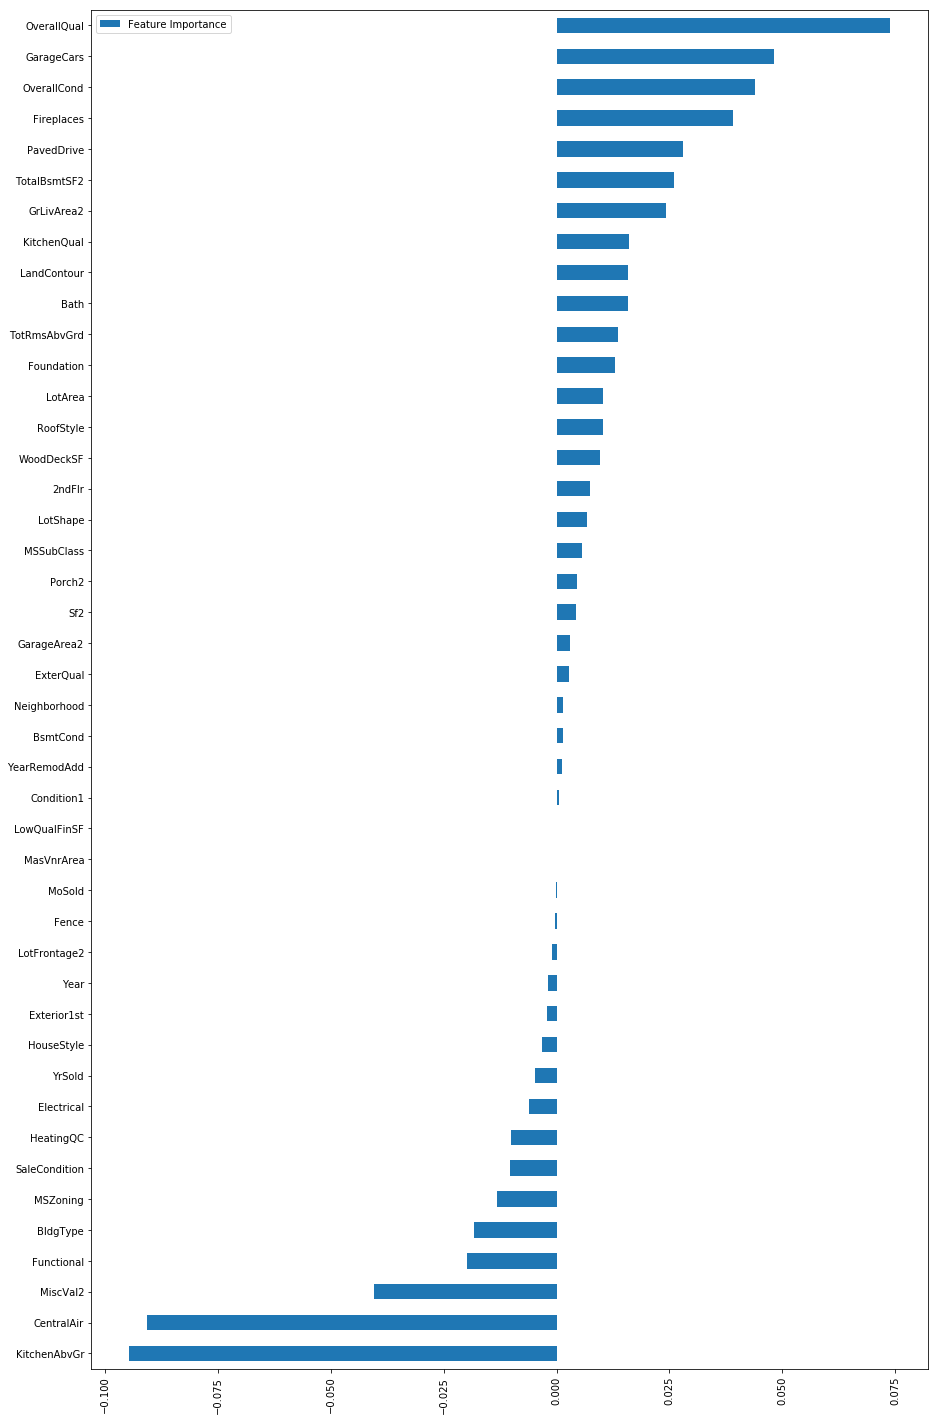

In [882]:
FI_en = pd.DataFrame({"Feature Importance":en.coef_}, index=X_all.columns)
FI_en.sort_values("Feature Importance",ascending=False)
FI_en[FI_en["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [1240]:
from sklearn.decomposition import PCA
pca = PCA(n_components=35)
X_trainpca =pca.fit_transform(X_train)
#matrix=pca.transform(X_test)
#pca.singular_values_
#pca.explained_variance_
X_testpca=pca.transform(X_test)#test[Features])
testpca=pca.transform(test[Features])
trainpca=pca.transform(train[Features])

In [1241]:
gbm3 =  Lasso(alpha=.001)#ElasticNet(alpha=.001, l1_ratio=.2)#xgb.XGBRegressor(n_estimators=100)#
gbm3.fit(X_trainpca, y_train.apply(log))
predictions13 = gbm3.predict(X_testpca)
print(mean_squared_log_error(y_train,np.exp(gbm3.predict(X_trainpca))))
print(mean_squared_log_error(y_test,np.exp(predictions13)))

0.0199707484289
0.0199002603376


In [1078]:
ids = test['Id']
gbm3.fit(trainpca, y_all.apply(log))
Predictions9 = gbm3.predict(testpca)
#predictions.sample(5)

output = pd.DataFrame({ 'Id' : ids, 'SalePrice': np.exp(Predictions9) })
output.to_csv('realestate-predictions15.csv', index = False)
output.head()

,Id,SalePrice
0,1461,121428.793677
1,1462,162831.859054
2,1463,178544.828722
3,1464,200270.848376
4,1465,192482.335206


In [82]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(loss='huber', max_iter=10000)
sgd.fit(X_train, y_train)
predictions4= sgd.predict(X_test)
print(mean_squared_log_error(y_test, predictions4))

0.0335052884823


In [83]:
from sklearn.linear_model import SGDClassifier
sgc = SGDClassifier(loss='huber', penalty='elasticnet')
sgc.fit(X_train, y_train)
predictions5= sgc.predict(X_test)
print(mean_squared_log_error(y_test, predictions5))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.24984525906


In [1232]:
gbm = xgb.XGBRegressor(n_estimators=70)#9
gbm.fit(X_train, y_train.apply(log))
predictions3 = gbm.predict(X_test)
print(mean_squared_log_error(y_train, np.exp(gbm.predict(X_train))))
print(mean_squared_log_error(y_test, np.exp(predictions3)))

0.0106820313509
0.0188962637567


In [1084]:
ids = test['Id']
gbm.fit(X_all, y_all.apply(log))
Predictions10 = gbm.predict(test[Features])
#predictions.sample(5)

output = pd.DataFrame({ 'Id' : ids, 'SalePrice': np.exp(Predictions10) })
output.to_csv('realestate-predictions16.csv', index = False)
output.head()

,Id,SalePrice
0,1461,124548.742188
1,1462,157587.968750
2,1463,180959.843750
3,1464,183137.484375
4,1465,202145.203125


In [1067]:
np.exp(predictions3)[:5]

array([ 144420.109375 ,   96326.6328125,  140802.84375  ,  205472.109375 ,
        161918.46875  ], dtype=float32)

In [1066]:
y_test[:5]

944     137500
1143     80000
796     143500
1410    230000
267     179500
Name: SalePrice, dtype: int64

In [1023]:
test.MiscVal2.value_counts().sum()

1459

In [92]:
en.fit(X_all, y_all.apply(log))
ids = test['Id']
Predictions = en.predict(test[Features])
#predictions.sample(5)

output = pd.DataFrame({ 'Id' : ids, 'SalePrice': np.exp(Predictions) })
output.to_csv('realestate-predictions3.csv', index = False)
output.head()

,Id,SalePrice
0,1461,117817.694736
1,1462,145163.797287
2,1463,183136.536378
3,1464,200318.277572
4,1465,197550.288798


In [ ]:
 	Id 	SalePrice
0 	1461 	119777.952553
1 	1462 	152147.145214
2 	1463 	183471.787454
3 	1464 	199992.910910
4 	1465 	193083.317930

In [230]:
svr1.fit(X_all, y_all)
ids = test['Id']
Predictions2 = svr1.predict(test[Features])
#predictions.sample(5)

output = pd.DataFrame({ 'Id' : ids, 'SalePrice': Predictions2 })
output.to_csv('realestate-predictions4.csv', index = False)
output.head()

,Id,SalePrice
0,1461,124121.709925
1,1462,157455.159610
2,1463,201196.273989
3,1464,201430.511891
4,1465,172270.683696


In [ ]:
 	Id 	SalePrice
0 	1461 	125887.668441
1 	1462 	163301.144766
2 	1463 	186854.334372
3 	1464 	194957.157266
4 	1465 	187515.206061

In [400]:
lasso.fit(X_all, y_all.apply(log))
ids = test['Id']
Predictions3 = lasso.predict(test[Features])
#predictions.sample(5)

output = pd.DataFrame({ 'Id' : ids, 'SalePrice': np.exp(Predictions3) })
output.to_csv('realestate-predictions5.csv', index = False)
output.head()

,Id,SalePrice
0,1461,118688.082660
1,1462,155484.875830
2,1463,182479.640203
3,1464,200225.483951
4,1465,194910.651104


In [401]:
Predictions4=(np.exp(Predictions) + np.exp(Predictions3) )/2
output = pd.DataFrame({ 'Id' : ids, 'SalePrice': Predictions4 })
output.to_csv('realestate-predictions11.csv', index = False)
output.head()

,Id,SalePrice
0,1461,118252.888698
1,1462,150324.336559
2,1463,182808.088291
3,1464,200271.880761
4,1465,196230.469951


In [ ]:

	Id 	SalePrice
0 	1461 	119233.017606
1 	1462 	153816.010522
2 	1463 	182975.713829
3 	1464 	200109.197430
4 	1465 	193996.984517

In [89]:
X_2nd = pd.DataFrame(en.predict(X_all), columns = ['en'])
X_2nd['lasso'] = pd.Series(lasso.predict(X_all))
X_2nd['svr1'] = pd.Series(svr1.predict(X_all))
#X_2nd['lsvr'] = pd.Series(lsvr.predict(X_all))
X_2nd['average']=(X_2nd['svr1']+X_2nd['en'])/2

In [85]:
X_2nd

,en,lasso,svr1,lsvr,average
0,210026.321927,216637.322346,200039.481184,160836.432333,205032.901555
1,191495.525542,171573.651358,190085.293111,135876.679550,190790.409326
2,226951.159156,227621.570159,216933.585904,173106.243509,221942.372530
3,152382.034429,159976.930190,156918.813232,95923.606105,154650.423831
4,287128.479182,281970.596979,270803.286102,228807.995522,278965.882642
5,179544.953101,167865.848334,176253.765934,129096.102381,177899.359518
6,267859.056947,264804.549483,256593.735083,220669.735876,262226.396015
7,241857.500910,228838.104994,236136.982887,184876.369243,238997.241899
8,156500.423892,160185.844983,150263.299881,107617.051759,153381.861887
9,90410.956518,88646.958732,108052.137076,44179.206253,99231.546797


In [277]:
en2 = ElasticNet(alpha=2, max_iter=5000)
en2.fit(X_2nd, y_test)
predictions11=en2.predict(X_2nd)
mean_squared_log_error(y_test, predictions11)

0.026461253855990501

In [90]:
Pred = pd.DataFrame(en.predict(test[Features]), columns=['en'])
Pred['lasso']=lasso.predict(test[Features])
Pred['svr1']=svr1.predict(test[Features])
#Pred['lsvr']=lsvr.predict(test[Features])
Pred['average']=(Pred['svr1']+Pred['en'])/2

In [87]:
Pred

,en,lasso,svr1,lsvr,average
0,121313.955092,120501.627419,125887.668441,68740.765243,123600.811766
1,162380.443806,164492.661521,163301.144766,118845.791463,162840.794286
2,193699.961963,190442.203121,186854.334372,151340.932311,190277.148168
3,199060.874852,193062.950613,194957.157266,150324.805892,197009.016059
4,189559.541034,190238.971795,187515.206061,136500.920750,188537.373547
5,189267.797602,186536.669816,185898.213627,140540.005986,187583.005615
6,180543.114296,174464.669208,176551.189563,131128.412525,178547.151930
7,169995.743000,175467.755207,170179.317427,127583.296790,170087.530213
8,191433.542705,194454.812895,189496.270982,144651.977370,190464.906843
9,113037.654136,110360.858181,114415.576036,69428.080493,113726.615086


In [94]:
en2 = ElasticNet(alpha=10, max_iter=1000)
en2.fit(X_2nd, y_all)
Pred2=en2.predict(Pred)
#svr2 = svm.SVR(kernel='linear', C=10)
#svr2.fit(X_2nd, y_all)
#Pred2=svr2.predict(Pred)
output = pd.DataFrame({ 'Id' : ids, 'SalePrice': Pred2 })
output.to_csv('realestate-predictions7.csv', index = False)
output.head()

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Id,SalePrice
0,1461,124564.620028
1,1462,162815.237015
2,1463,194113.409075
3,1464,203734.657596
4,1465,190256.754376


In [95]:
output[output['SalePrice']<0]

,Id,SalePrice


In [ ]:
Id 	SalePrice
0 	1461 	124564.620028
1 	1462 	162815.237015
2 	1463 	194113.409075
3 	1464 	203734.657596
4 	1465 	190256.754376
Id 	SalePrice
0 	1461 	122643.442621
1 	1462 	162173.924415
2 	1463 	192370.111225
3 	1464 	198985.234742
4 	1465 	189759.258419

Id 	SalePrice
0 	1461 	124867.491659
1 	1462 	165129.620730
2 	1463 	183176.301039
3 	1464 	193970.606381
4 	1465 	198726.025640

In [235]:
Predictions7=pd.read_csv('realestate-predictions7.csv', usecols=['SalePrice'])

In [236]:
Predictions7.head()

,SalePrice
0,124020.819647
1,166657.498850
2,193521.377461
3,197290.443674
4,185467.595295


In [237]:
abs((Predictions7-output)['SalePrice']).describe()

count     1459.000000
mean      6594.064722
std       5658.699378
min          0.221654
25%       2413.066376
50%       5196.940235
75%       9367.280373
max      58147.675396
Name: SalePrice, dtype: float64

In [197]:
X=((pd.read_csv('realestate-predictions6.csv') + output)/2)#.apply(lambda a: int(a['Id']), axis=1)

In [198]:
X['Id']=X.apply(lambda a: int(a['Id']), axis=1)

In [199]:
X.to_csv('realestate-predictions7.csv', index = False)

In [201]:
mlr.fit(X_all, y_all)
ids = test['Id']
Predictions11 = mlr.predict(test[Features])

output = pd.DataFrame({ 'Id' : ids, 'SalePrice': Predictions11 })
#output.to_csv('realestate-predictions7.csv', index = False)
output.head()

,Id,SalePrice
0,1461,118233.645218
1,1462,183822.184469
2,1463,175240.153696
3,1464,175517.021792
4,1465,171629.898760


In [ ]:

	Id 	SalePrice
0 	1461 	124065.668229
1 	1462 	170215.798909
2 	1463 	196615.180668
3 	1464 	197583.880657
4 	1465 	182931.233781


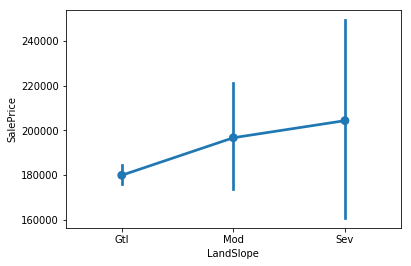

In [1184]:
sns.pointplot(x='LandSlope', y='SalePrice', data=train)

In [1190]:
train.LandSlope.value_counts().to_dict()

{'Gtl': 1382, 'Mod': 65, 'Sev': 13}

In [1086]:
train.loc[4]

Id                     5
MSSubClass             5
MSZoning               4
LotFrontage           84
LotArea                8
Street              Pave
Alley                NaN
LotShape               1
LandContour            1
Utilities         AllPub
LotConfig            FR2
LandSlope            Gtl
Neighborhood          16
Condition1             2
Condition2          Norm
BldgType               1
HouseStyle             5
OverallQual            8
OverallCond            5
YearBuilt           2000
YearRemodAdd        2000
RoofStyle              1
RoofMatl         CompShg
Exterior1st           13
Exterior2nd      VinylSd
MasVnrType       BrkFace
MasVnrArea           350
ExterQual              1
ExterCond             TA
Foundation             2
                  ...   
PavedDrive             2
WoodDeckSF             2
OpenPorchSF           84
EnclosedPorch          0
3SsnPorch              0
ScreenPorch            0
PoolArea               0
PoolQC               NaN
Fence                  0
